<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/TP_microestados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

# 1. Instalacion de paquetes

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [5]:
if is_runing_into_colab_env():
    !pip install mne

# 2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/dataset`.

In [6]:
filename     = "procesados-20210908T224817Z-001.zip"
dataset_url  =  f'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/{filename}'
dataset_path = "dataset"

if is_runing_into_colab_env():
    !cd ~
    !rm -rf procesados
    !rm -rf dataset
    !rm -rf {filename}
    !wget  {dataset_url}
    !unzip {filename}
    !mv procesados dataset
    !apt install -y tree
    clear_output()
    !tree dataset

dataset
├── suj_10_bl_1.txt
├── suj_10_bl_2.txt
├── suj_12_bl_1.txt
├── suj_12_bl_2.txt
├── suj_13_bl_1.txt
├── suj_13_bl_2.txt
├── suj_8_bl_1.txt
├── suj_8_bl_2.txt
├── suj_9_bl_1.txt
└── suj_9_bl_2.txt

0 directories, 10 files


# 3. Importa libreria del proyecto

In [7]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp'):
        print('Pull...\n')
        !cd dm-cyt-tp; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp.git

Pull...

remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 15), reused 18 (delta 9), pack-reused 0
Unpacking objects: 100% (30/30), done.
From https://github.com/magistery-tps/dm-cyt-tp
 * branch            main       -> FETCH_HEAD
   4cd260e..4b90217  main       -> origin/main
Updating 4cd260e..4b90217
Fast-forward
 README.md               |   3 +-
 TP_microestados.ipynb   | 368 +++++++++++++++++++++++++++++++++++++-----------
 docs/TP1_clustering.pdf | Bin 0 -> 228184 bytes
 src/pca.py              |  12 ++
 src/plot/__init__.py    |   1 +
 src/plot/pca.py         |  21 +++
 6 files changed, 325 insertions(+), 80 deletions(-)
 create mode 100644 docs/TP1_clustering.pdf
 create mode 100644 src/pca.py
 create mode 100644 src/plot/pca.py


In [8]:
sys.path.append('/content/dm-cyt-tp/src' if is_runing_into_colab_env() else './src')

# 4. Importa paquetes externos

In [9]:
import numpy as np
import pandas as pd

from scipy.signal import find_peaks

from sklearn.cluster          import KMeans, DBSCAN   #opcion kmeans y dbscan definir cuales se usan
from sklearn.metrics          import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy  import dendrogram, linkage, cophenet, fcluster
from sklearn.preprocessing    import MinMaxScaler

from plot import plot_gfp, \
                 plot_silhoutte_modificado2, \
                 plot_eeg_pca, \
                 plot_eeg_topology_on_axis, \
                 plot_egg_on_axis, \
                 plot_eegs_summary, \
                 plot_sx_reduce_noise, \
                 plot_maps_pca, \
                 plot_vectores_kmeans, \
                 plot_silhoutte, \
                 plot_dendrogram, \
                 plot_distancia_euclidea

from gfp  import find_gfp_peaks, \
                 show_complete_gfp_peaks_summary, \
                 reduce_noise_pca

from eeg  import get_info_eeg_and_montage, \
                 eegs_total_mean, \
                 order_asc_by_subject, \
                 order_asc_by_resting_state

from gev        import calculo_gev

from clustering import van_dongen, \
                       kmeans2, \
                       silhoutte_modificado2

from read_eeg  import load_eeg_dataset
from util      import concat_fields, data_field
import mne
import matplotlib.pyplot as plt

El registro de EEG de 30 canales viene en formato txt (cada uno de los canales es una señal de un electrodo). La frecuencia de muestreo de la señal orginal es de 256 Hz, luego fue filtrada y resampleada a 128 Hz.

## 5. Lectura de EEG's

Para cada persona identificada con el número que sigue a "suj_" se hicieron dos registros para cada persona, uno antes de aprender algo "bl_1" y el otro despues de aprender algo "bl_2"

In [10]:
eegs = load_eeg_dataset('./dataset/*')

In [11]:
eegs[1].to_dict()

{'data': array([[  8.8053  ,   2.8521  ,   8.4599  , ...,  -7.5154  ,   5.6913  ,
         -18.52    ],
        [ 12.527   ,   4.2622  ,  10.628   , ..., -10.427   ,   5.6633  ,
         -21.176   ],
        [ 17.019   ,   5.8066  ,   9.0612  , ...,  -9.7515  ,   8.0545  ,
         -22.238   ],
        ...,
        [ -9.8746  ,  -0.13757 ,   4.4853  , ...,   3.5603  ,  -5.5463  ,
           1.5543  ],
        [ -4.883   ,   1.2051  ,   2.5195  , ...,   5.6999  ,  -1.6198  ,
          -1.4655  ],
        [  1.134   ,   2.622   ,   0.058498, ...,   8.3902  ,   3.0574  ,
          -5.5949  ]]),
 'nchannels': 30,
 'nsamples': 7681,
 'resting_state': '1',
 'sfrequency': 128,
 'subject': '8'}

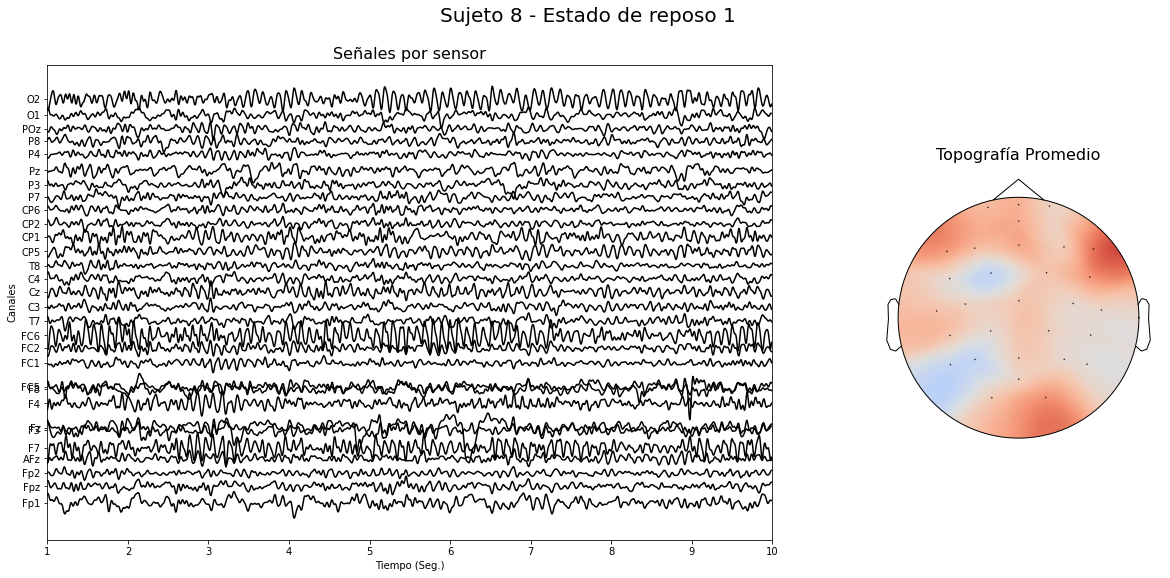

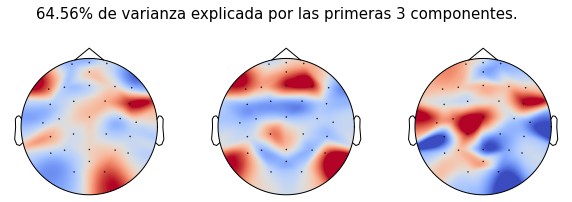

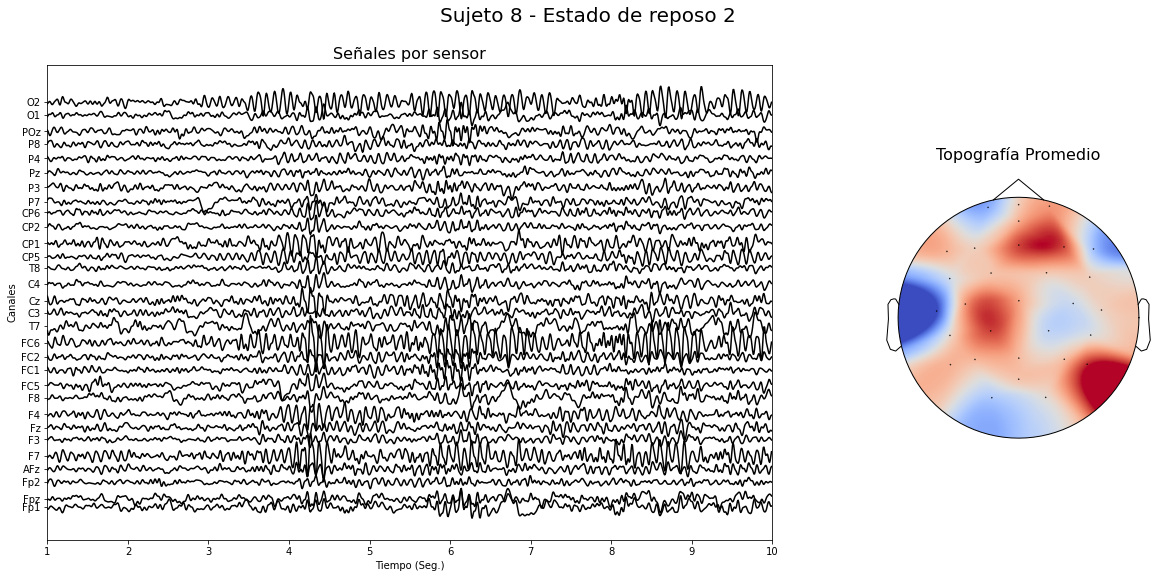

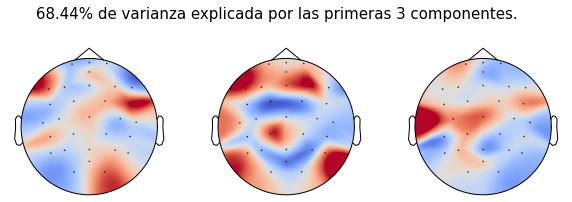

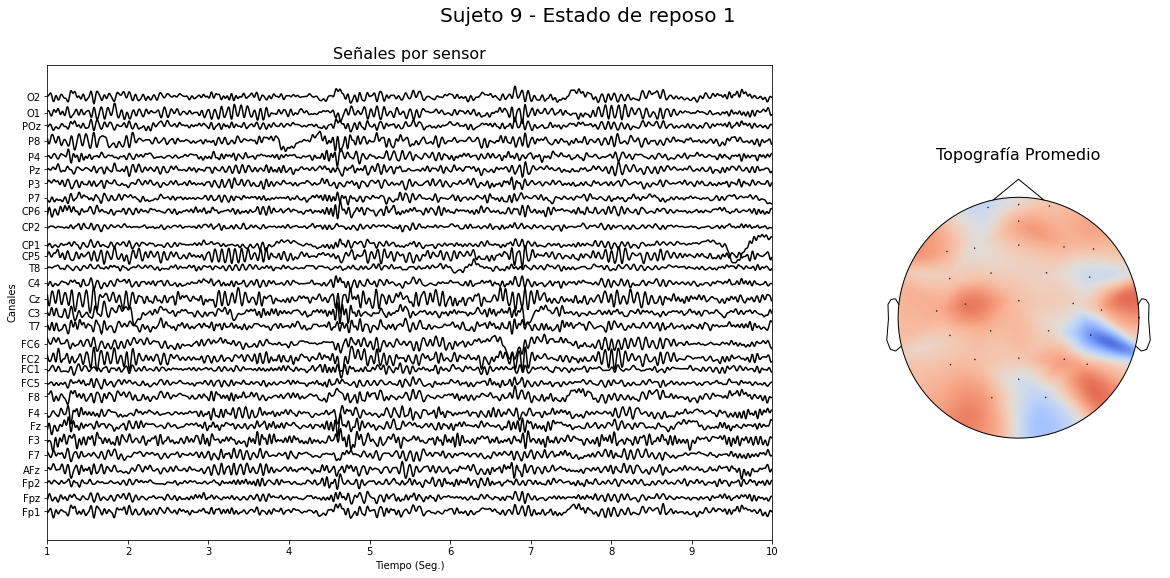

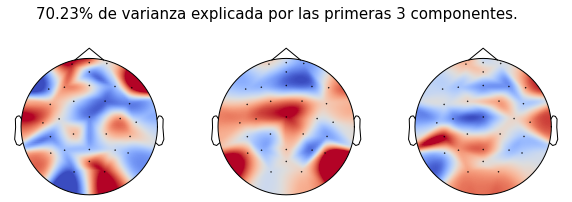

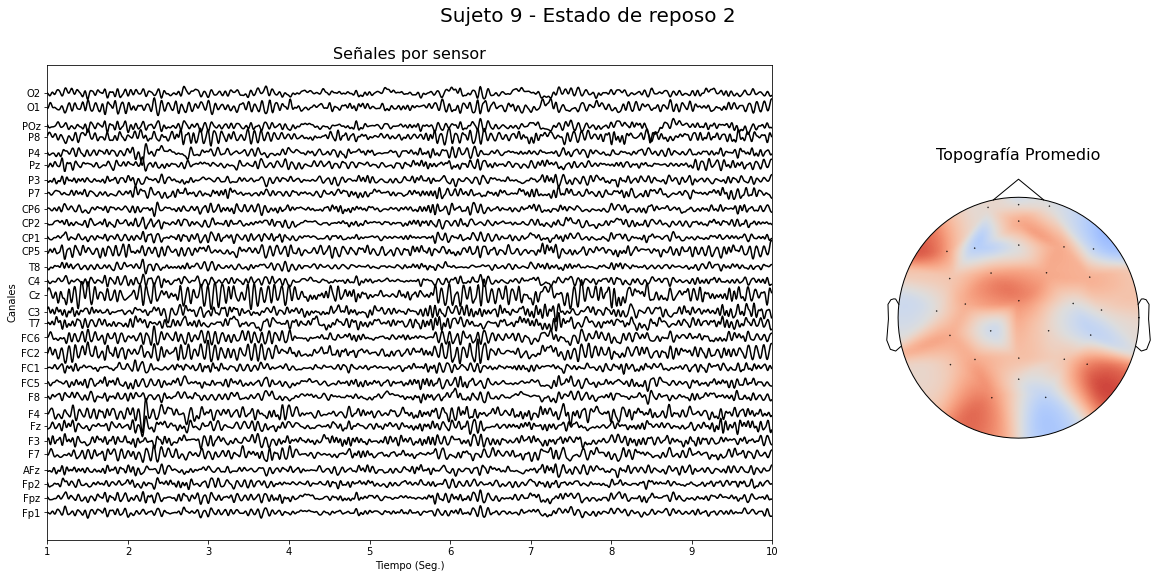

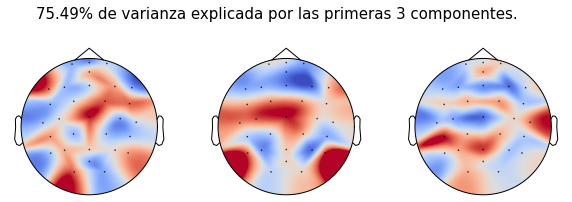

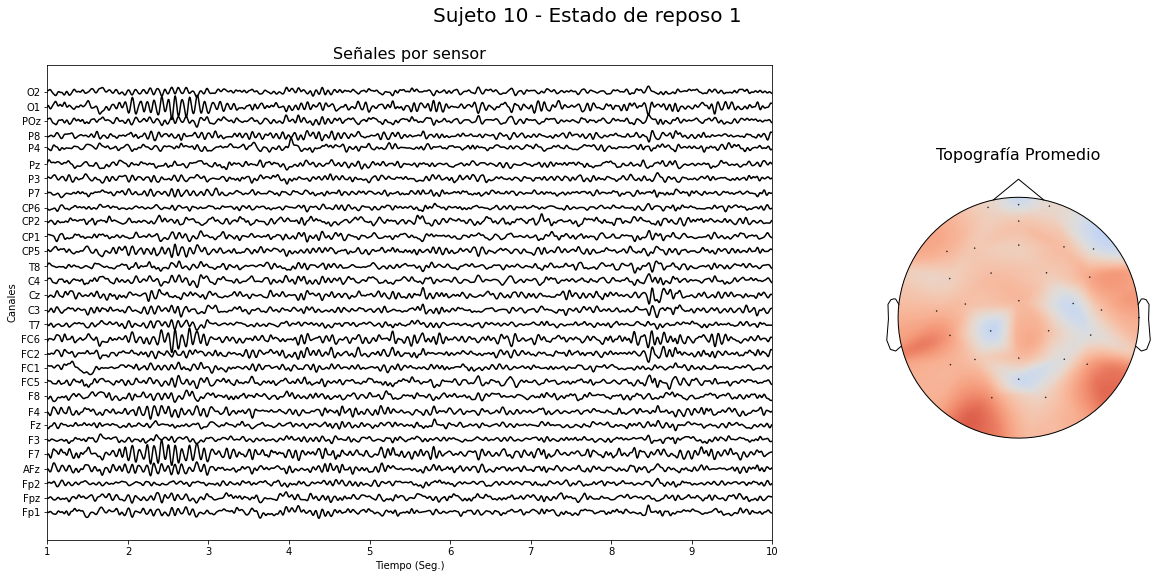

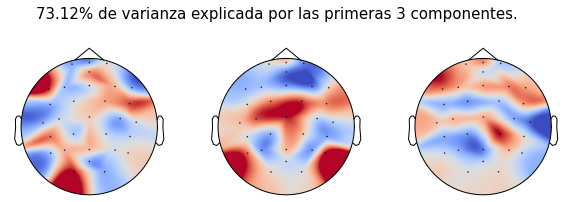

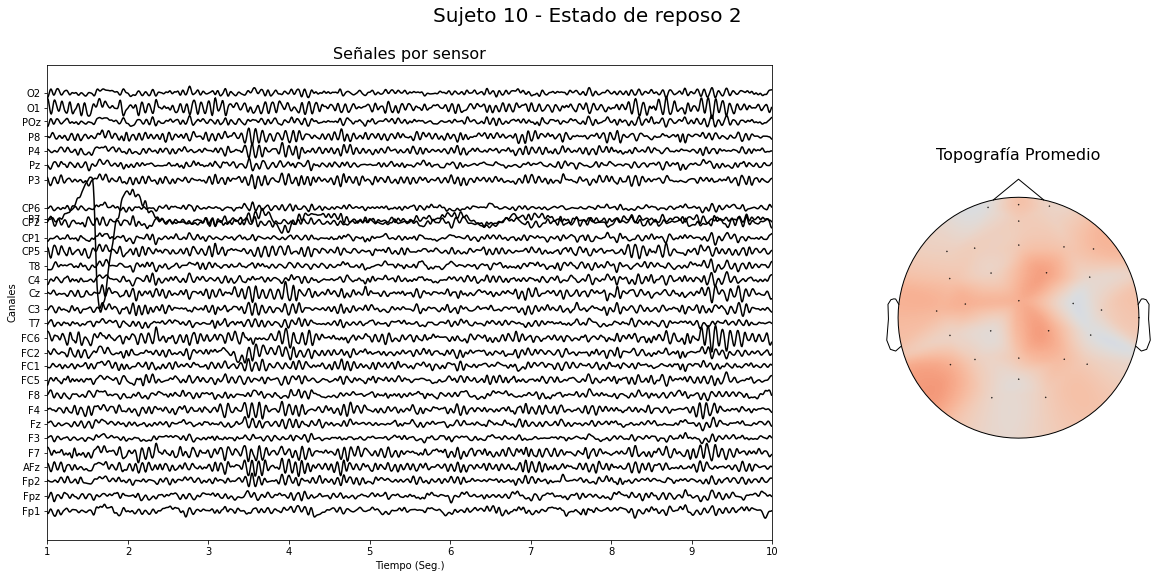

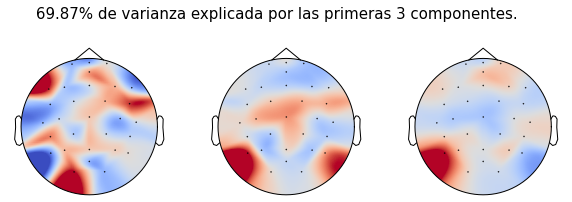

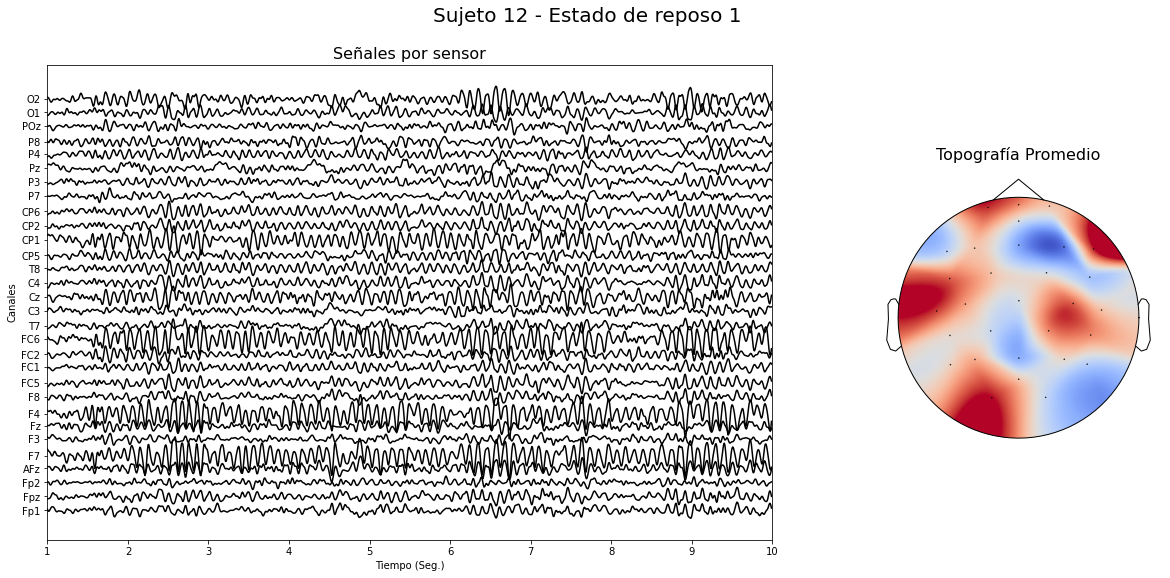

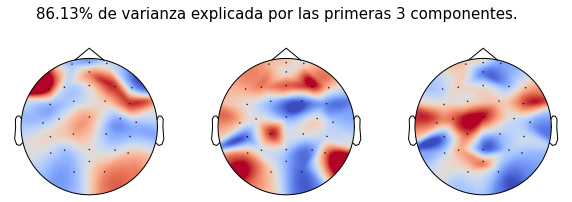

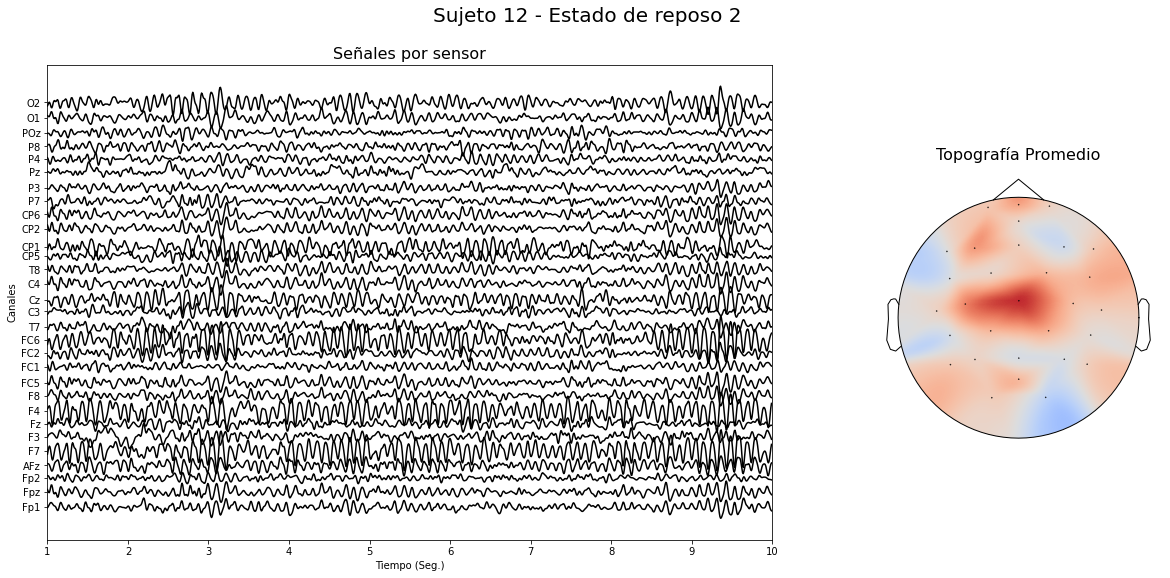

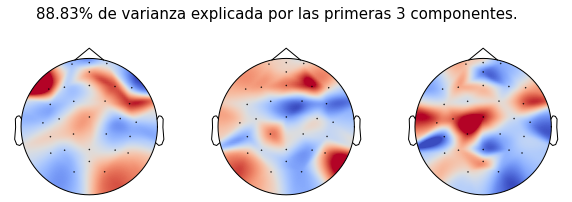

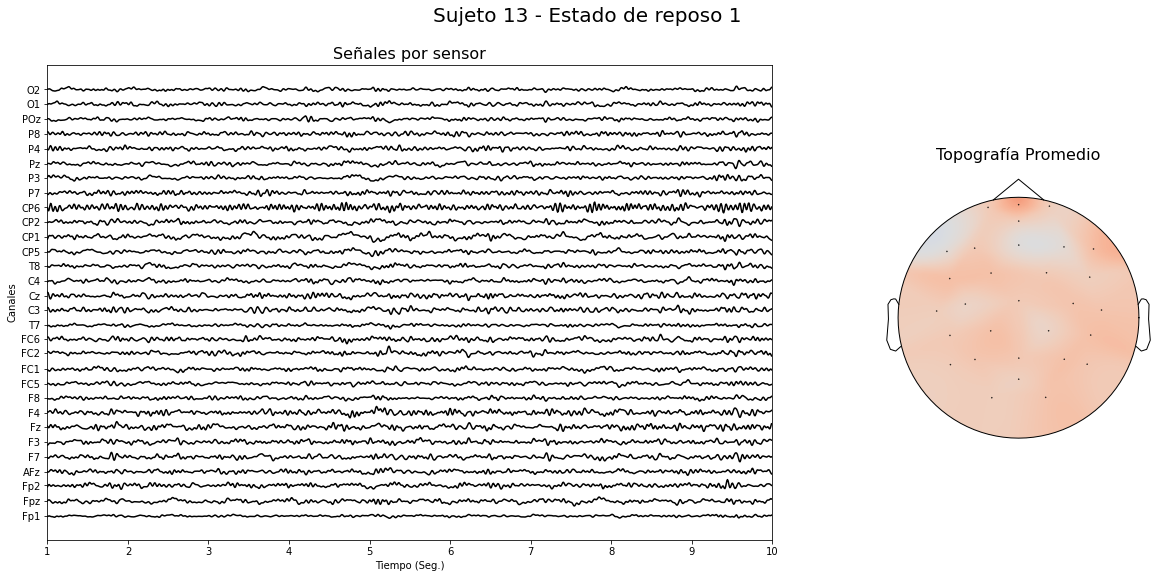

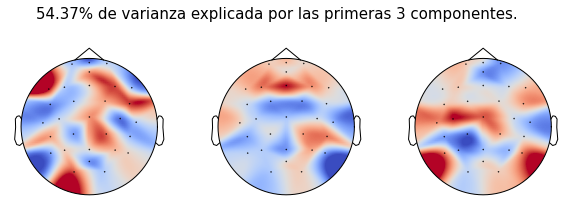

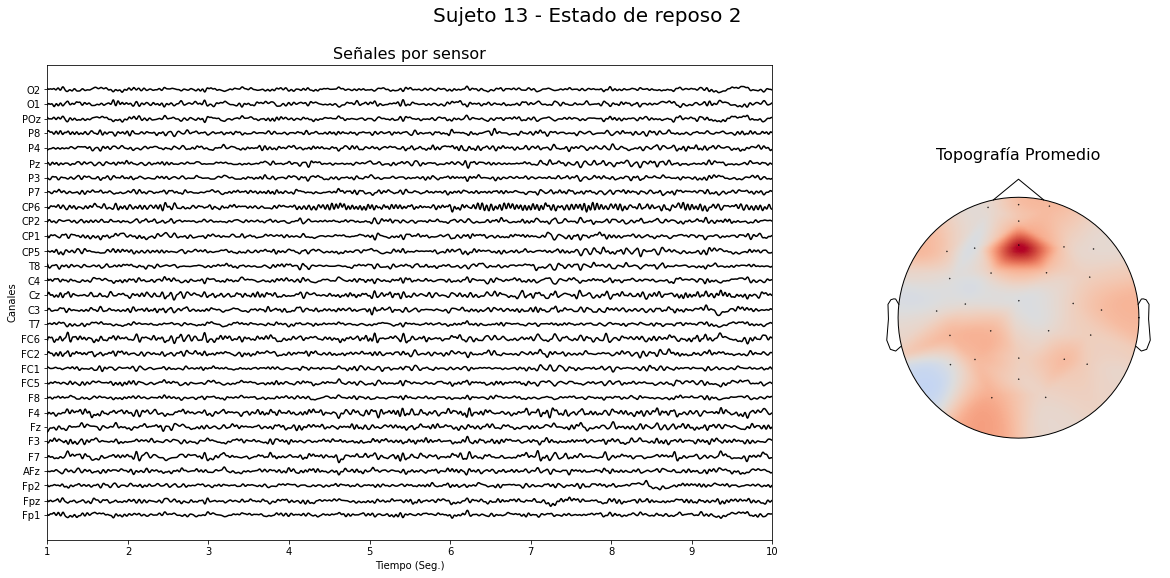

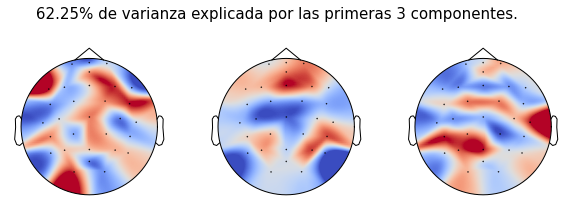

In [12]:
info_eeg, montage = get_info_eeg_and_montage()

plot_eegs_summary(eegs, info_eeg, montage)

In [13]:
promedios_totales = eegs_total_mean(eegs)

print(promedios_totales.max(axis=None))
print(promedios_totales.min(axis=None))

0.019974773268228982
-0.02942990907942698


Todos los promedios dan cercanos a 0 porque los datos procesados tienen filtrada las bajas frecuencias. 

In [14]:
print(promedios_totales.max(axis=1))
print(promedios_totales.min(axis=1))

[0.00713698 0.01143988 0.01961749 0.00627234 0.01742602 0.01997477
 0.00538763 0.01100957 0.01815815 0.0092637 ]
[-0.00891953 -0.00937769 -0.02586782 -0.00552607 -0.02942991 -0.00530727
 -0.00441476 -0.02093899 -0.00970843 -0.01089066]


In [15]:
eegs_subject=order_asc_by_subject(eegs)
eegs_resting_state=order_asc_by_resting_state(eegs)

Análisis de componentes principales - distinguiendo por resting_state -  resting_state=1

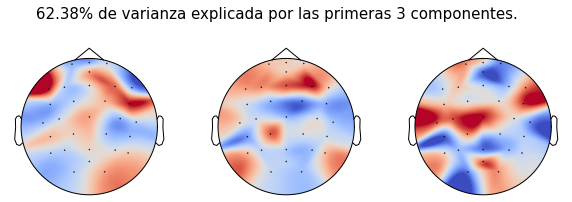

In [16]:
plot_eeg_pca(info_eeg, np.transpose(concat_fields(eegs_resting_state[0:5], data_field)))

Análisis de componentes principales - distinguiendo por resting_state -  resting_state=2

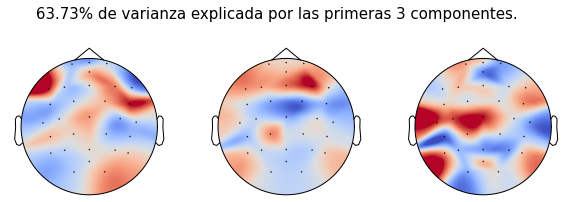

In [17]:
plot_eeg_pca(info_eeg, np.transpose(concat_fields(eegs_resting_state[5:], data_field)))

Los registros fueron tomados con el montage 10-20.
Tengo que armarlo que los electrodos tengan esta distribución:
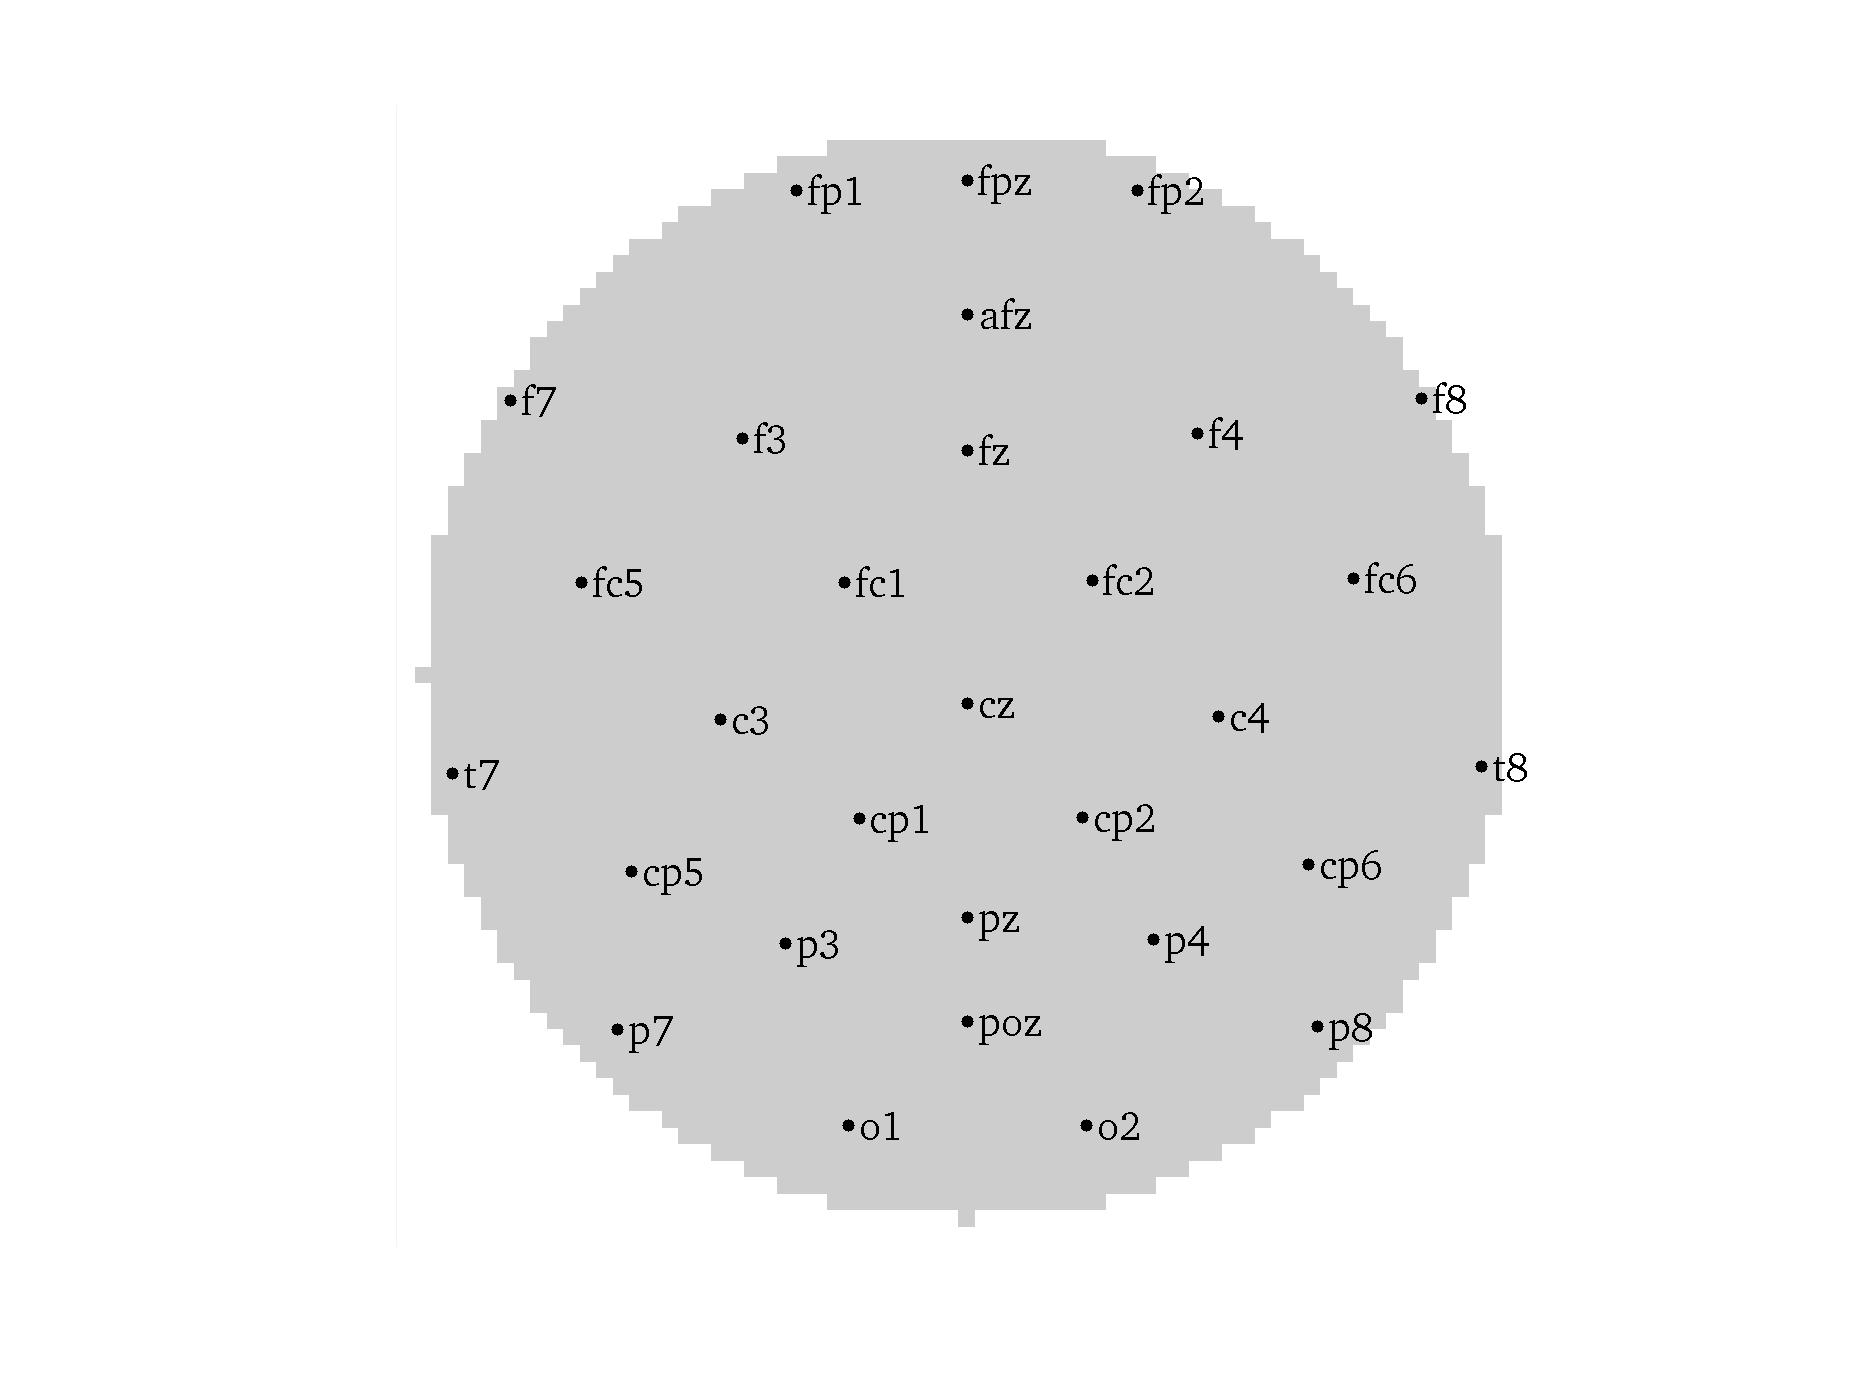

# 6. Obtención de GFP - Tarea 1

Para los cálculos a continuación uso ref https://link.springer.com/content/pdf/10.1007/s10548-008-0054-5.pdf.

Siendo la media $\bar{u}=\frac{1}{c}\sum_{i=1}^{c}{u_{i}}$   donde $c$ es la cantidad total de canales y $u_{i}$ es la medición del i-ésimo canal.

El *average reference* se calcula $v_i=u_i-\bar{u}$ \\
El *Global field power* (GFP) se calcula como 
$GFP(n)=\sqrt{\frac{1}{c}\sum_{i=1}^{c}v_{i}^2}$ (para cada tiempo *t* o muestra *n*).
Los picos de GCP se encuentran con la función find_peaks. Para evitar que estén demasiado próximos entre sí se elige el parámetro distancia.
Por ejemplo eligiendo distance=8 y con la frecuencia de muestreo de 128 Hz los picos deberán estar alejados en no menos de 60 ms (aproximadamente).

Para cada indice identificados del máximo de GCP se calcula cuanto vale $v_{i}$.

Antes distance=8 y prominence=1, si se dejan iguales a 1 y 0 respectivamente coinciden la cantidad de picos con lo obtenido en la función locmax de Frederic (13135).
  

- Cantidad de picos de GFP: 13135
- El intervalo temporal entre máximos de GFP promedio es: 45.684744746459565 ms
- El intervalo temporal entre máximos de GFP más chico es: 15.625 ms
- El intervalo temporal entre máximos de GFP más grande es: 242.1875 ms


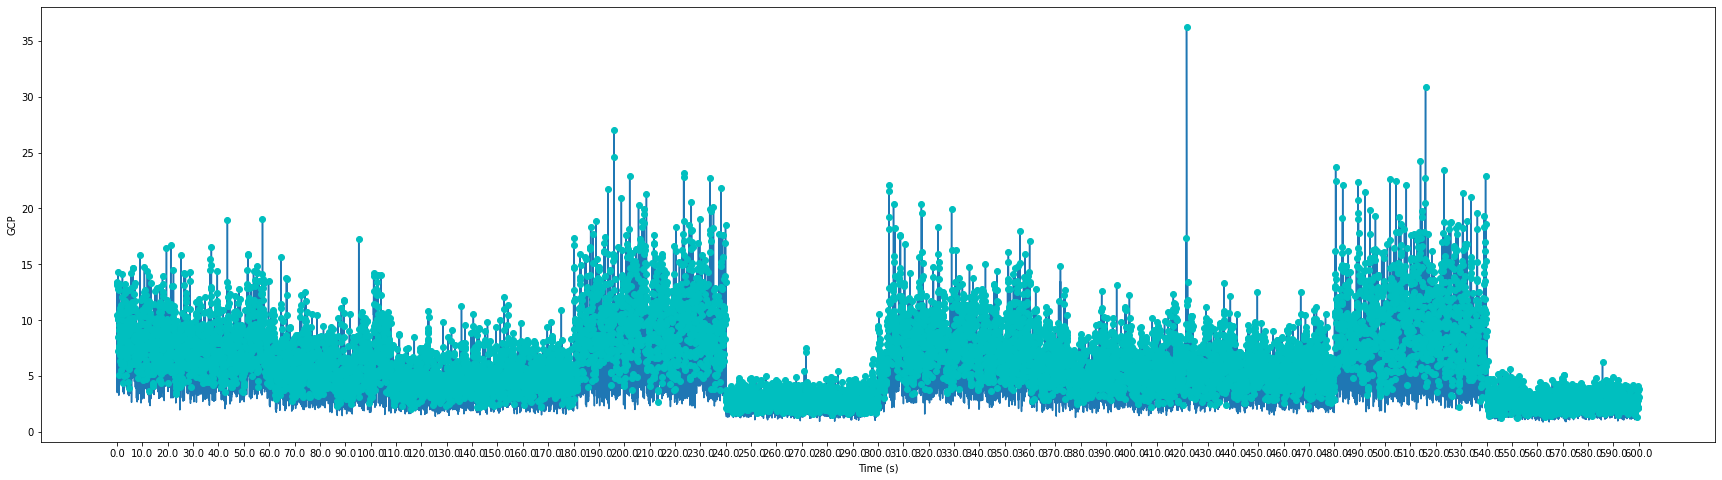

In [18]:
gfp, peaks, v_i_peaks, gfp_values, gfp2, n_gfp = find_gfp_peaks(
    eeg_data   = concat_fields(eegs_resting_state, data_field), 
    prominence = 0, 
    distance   = 1,
    height     = 0
)

show_complete_gfp_peaks_summary(
    gfp, 
    peaks, 
    sfrequency = eegs[0].sfrequency
)

In [19]:
data = np.transpose(v_i_peaks)
data.shape

(13135, 30)

In [20]:
df = pd.DataFrame(data, columns=montage.ch_names)

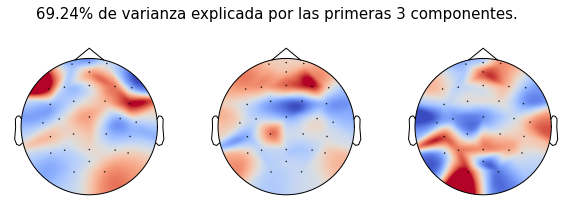

In [21]:
plot_eeg_pca(info_eeg, np.transpose(df))

### Alternativa de Reducción de ruido vía PCA (Tarea 1)

Se calcula la matriz de PCA y se toman pocas componentes, luego se recompone la señal y se compara visualmente con la señal original de los canales.  Esta reducción se puede incluir en la función de búsqueda de GFP.

In [22]:
Xnl,acum=reduce_noise_pca(v_i_peaks,8)

In [23]:
acum

array([0.47335095, 0.59974586, 0.69241116, 0.76631523, 0.80769363,
       0.84044434, 0.86322782, 0.88313741])

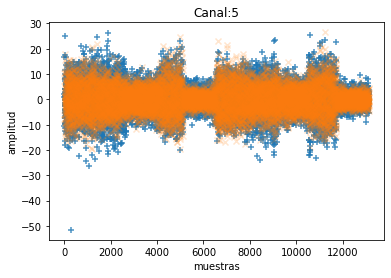

In [24]:
nro_canal=5
plot_sx_reduce_noise(v_i_peaks,Xnl,5)

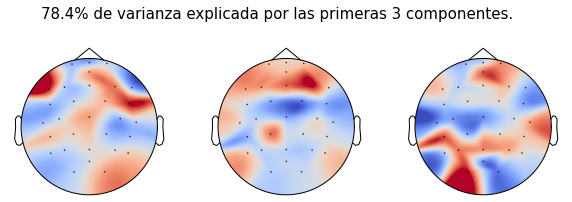

In [25]:
df = pd.DataFrame(Xnl.T, columns=montage.ch_names)
plot_eeg_pca(info_eeg, np.transpose(df))

Si decidimos sacar los 

In [26]:
Xnl,acum=reduce_noise_pca(np.transpose(concat_fields(eegs_resting_state, data_field)),12)

In [27]:
acum

array([0.40531519, 0.53572948, 0.62918945, 0.69932145, 0.74547039,
       0.78472106, 0.81285319, 0.83766171, 0.85757893, 0.87607831,
       0.89063271, 0.90315689])

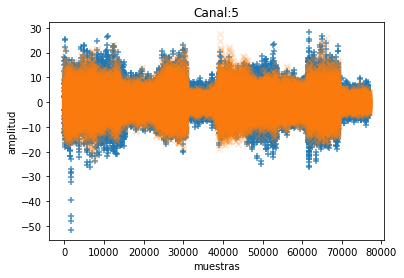

In [28]:
nro_canal=3
plot_sx_reduce_noise(np.transpose(concat_fields(eegs_resting_state, data_field)),Xnl,5)

- Cantidad de picos de GFP: 13056
- El intervalo temporal entre máximos de GFP promedio es: 45.96119781692838 ms
- El intervalo temporal entre máximos de GFP más chico es: 15.625 ms
- El intervalo temporal entre máximos de GFP más grande es: 242.1875 ms


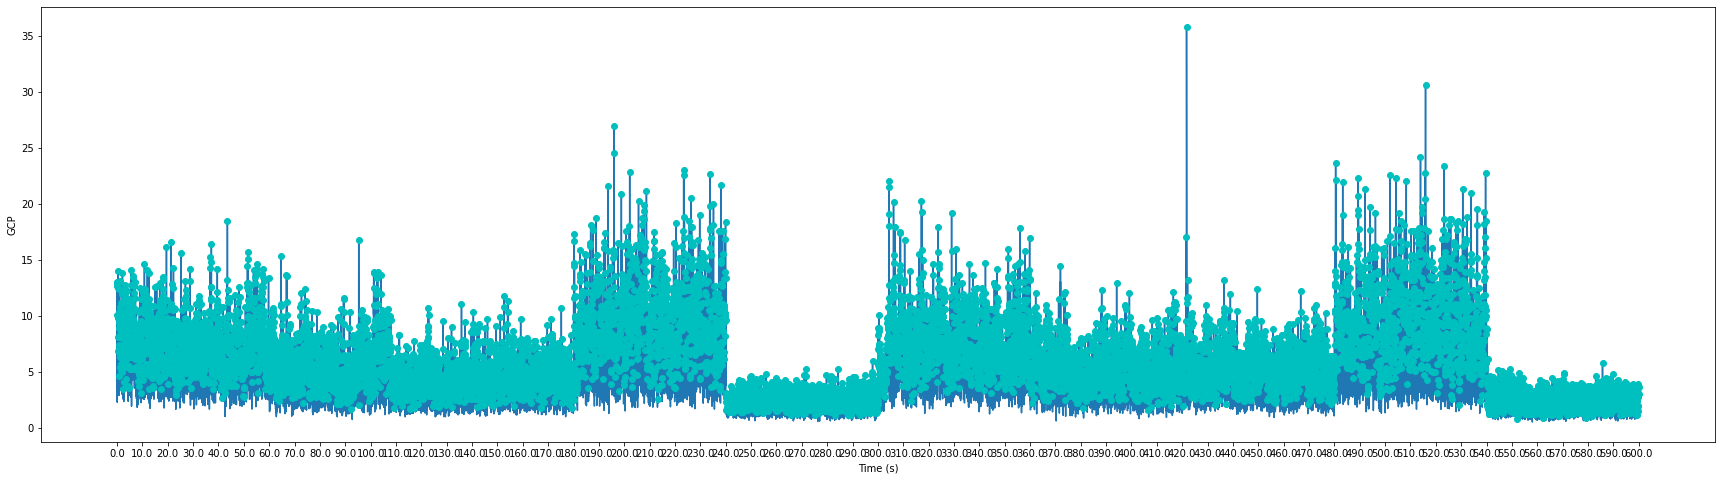

In [83]:
gfp, peaks, v_i_peaks, gfp_values, gfp2, n_gfp = find_gfp_peaks(
    eeg_data   = Xnl.T, 
    prominence = 0, 
    distance   = 1,
    height     = 0
)

show_complete_gfp_peaks_summary(
    gfp, 
    peaks, 
    sfrequency = eegs[0].sfrequency
)

# 7. Cálculo de *kmeans* modificado - Tarea 2 

Mapas usados en todas las funciones a continuación:

In [84]:
X=v_i_peaks

*kmeans_gfp*

In [85]:
#n_clusters = 2
#maps_kmeans,labels_gfp,cv,gev,gev_sum = kmeans2(X, gfp,peaks, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

labels_gfp es un vector del mismo largo que gfp con el label del cluster.

maps_kmeans tiene dimensiones de cantidad de clusters por 30 canales

In [99]:
cv_list=[]
gev_list=[]
sil_list=[]
for k in range(2,11):
  maps_kmeans,labels_gfp,cv,_,gev_sum = kmeans2(X, gfp,peaks, k, n_runs=100, maxerr=1e-6, maxiter=500)
  sil_mean = np.mean(silhoutte_modificado2(maps_kmeans, X,labels_gfp, ch, k))
  cv_list.append(cv)
  gev_list.append(gev_sum)
  sil_list.append(sil_mean)

cv_list
gev_list
sil_list

	K-means run 36/100 did NOT converge after 500 iterations.
	K-means run 36/100 did NOT converge after 500 iterations.
	K-means run 36/100 did NOT converge after 500 iterations.
	K-means run 36/100 did NOT converge after 500 iterations.
	K-means run 18/100 did NOT converge after 500 iterations.
	K-means run 18/100 did NOT converge after 500 iterations.
	K-means run 18/100 did NOT converge after 500 iterations.
	K-means run 18/100 did NOT converge after 500 iterations.
	K-means run 20/100 did NOT converge after 500 iterations.
	K-means run 20/100 did NOT converge after 500 iterations.
	K-means run 20/100 did NOT converge after 500 iterations.
	K-means run 20/100 did NOT converge after 500 iterations.
	K-means run 34/100 did NOT converge after 500 iterations.
	K-means run 34/100 did NOT converge after 500 iterations.
	K-means run 34/100 did NOT converge after 500 iterations.
	K-means run 34/100 did NOT converge after 500 iterations.
	K-means run 38/100 did NOT converge after 500 iteration

[0.21186912007517614,
 0.2069376944698995,
 0.2634928765309302,
 0.23500027030470597,
 0.2314902192556247,
 0.2253284708731534,
 0.211532407935953,
 0.20080588357005852,
 0.21055054123314035]

Text(0, 0.5, 'cv')

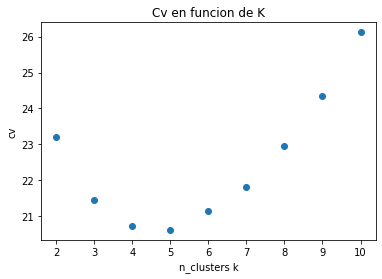

In [121]:
labels_clusters = range(2,11)
plt.plot(labels_clusters,cv_list,'o')
plt.title("Cv en funcion de K")
plt.xlabel("n_clusters k")
plt.ylabel("cv")

Text(0, 0.5, 'silhoutte')

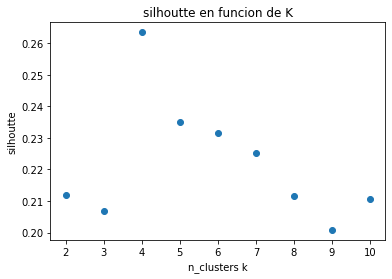

In [122]:
plt.plot(labels_clusters,sil_list,'o')
plt.title("silhoutte en funcion de K")
plt.xlabel("n_clusters k")
plt.ylabel("silhoutte")

Text(0, 0.5, 'gev')

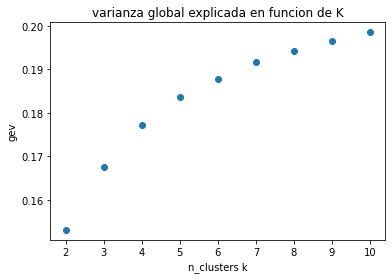

In [123]:
plt.plot(labels_clusters,gev_list,'o')
plt.title("varianza global explicada en funcion de K")
plt.xlabel("n_clusters k")
plt.ylabel("gev")

In [129]:
n_clusters=5

In [131]:
maps_kmeans,labels_gfp,cv,_,gev_sum = kmeans2(X, gfp,peaks, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

In [132]:
eeg1 = eegs[1].to_dict()
ch   = eeg1['nchannels']

For n_clusters = 5 The average silhouette_score is : 0.23487154568347116


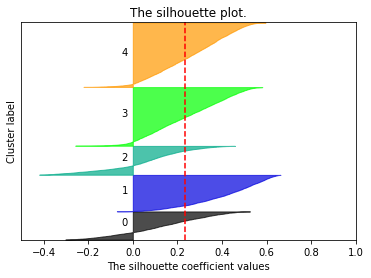

In [133]:
sil = silhoutte_modificado2(
    maps_kmeans, 
    X,
    labels_gfp, 
    ch,
    n_clusters
)

plot_silhoutte_modificado2(n_clusters, sil, labels_gfp)

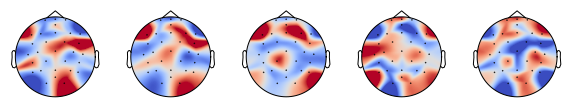

In [134]:
plot_maps_pca(maps_kmeans,n_clusters,info_eeg)

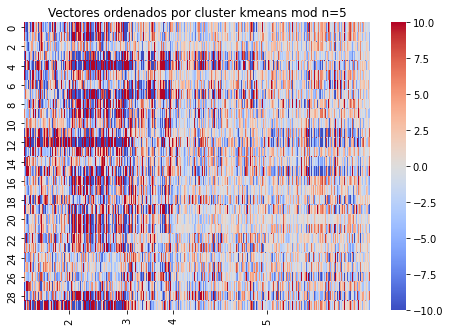

In [135]:
plot_vectores_kmeans(X,labels_gfp,n_clusters)

In [136]:
gfp2 = np.sum(gfp**2) # normalizing constant
gev2,gev_sum2=calculo_gev(X,maps_kmeans,30,4,gfp_values,gfp2,labels_gfp) #revisar valores

C.shape: 130565


In [137]:
print(gev_sum)
print(gev) # es el gev para cada uno de los prototipos del cluster

0.1836397637894265
[0.11518384 0.03786803]


# Cálculo con otros métodos. Tarea 3

### Nuevos modelos

*Kmeans - clásico*

In [113]:
kmeans = KMeans(n_clusters,random_state=0).fit(X.T)
labels_kmeans_clasico=kmeans.labels_

In [115]:
silhouette_avg = silhouette_score(X.T, labels_kmeans_clasico)
silhouette_avg

0.15898264722734753

In [116]:
sample_silhouette_values = silhouette_samples(X.T, labels_kmeans_clasico)
sample_silhouette_values

array([ 0.09189611,  0.03777899,  0.17528237, ...,  0.00468323,
       -0.00240589,  0.09264304])

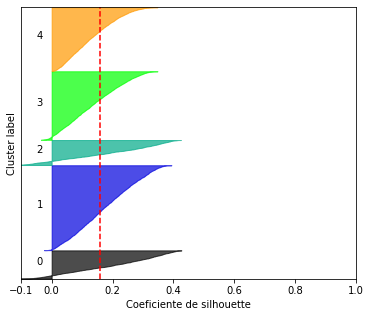

In [118]:
plot_silhoutte(
    df, 
    labels_kmeans_clasico,
    n_clusters, 
    sample_silhouette_values,
    silhouette_avg
)

*KMedoids*

In [50]:
#!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids 

In [119]:
KM_meta = KMedoids(
    n_clusters=n_clusters,
    init='k-medoids++'
).fit(X.T)

print(np.unique(KM_meta.labels_))
print(KM_meta.medoid_indices_)

[0 1 2 3 4]
[12265 11289 11050  5724 12170]


In [151]:
def calcula_sse_kmedoids(KM,d):
  se = []
  for i in range(0,KM.n_clusters):
    se.append(sum(d[KM.medoid_indices_[i],KM.labels_==i]**2))
  return sum(se)

In [149]:
print(silhouette_score(X.T,KM_meta.labels_,metric='euclidean'))

0.16488491087724497


In [155]:
range_k = [i for i in range(5,8)]
silh = []
sse = []
for k in range_k:
    #KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(X.T)
    KM_meta = KMedoids(n_clusters=k,metric="euclidean",init='heuristic').fit(X.T)

    silh.append(silhouette_score(X.T,KM_meta.labels_,metric='euclidean'))
    #sse.append(calcula_sse_kmedoids(KM_meta,X.T))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

plt.plot(range_k,sse,'r.-')
plt.ylabel('SSE')
plt.show()


IndexError: ignored

### Evaluación de modelos

In [138]:
# DataFrame with labels
tmp = pd.DataFrame({
    'Labels_kmeans_gfp': labels_gfp, 
    'Labels_kmeans_clasico': labels_kmeans_clasico
})

# crosstab: ct
ct0 = pd.crosstab(tmp['Labels_kmeans_gfp'], tmp['Labels_kmeans_clasico'])
ct0

Labels_kmeans_clasico    0     1    2     3     4
Labels_kmeans_gfp                                
0                      233   602  270   157   440
1                      865   258  727   224   120
2                      263   204  207   512   553
3                        2  1093    0  1686   755
4                        0  1941    3   729  1212

In [139]:
# DataFrame with labels
tmp = pd.DataFrame({
    'Labels_kmeans_gfp': labels_gfp, 
    'Labels_KMedoids': KM_meta.labels_
})

# crosstab: ct
ct1 = pd.crosstab(tmp['Labels_kmeans_gfp'], tmp['Labels_KMedoids'])
ct1

Labels_KMedoids       0    1    2     3     4
Labels_kmeans_gfp                            
0                   470  242  222   559   209
1                   142  713  817   283   239
2                   542  203  224   304   466
3                   649    0    0  1459  1428
4                  1406    2    0  1806   671

Criterio VanDongen

In [72]:
van_dongen(ct0)

0.9990826890315817

In [62]:
van_dongen(ct1)

0.852825721228737

Rand Score

In [140]:
ari0 = adjusted_rand_score(labels_gfp, labels_kmeans_clasico)
ari0

0.13490546075250176

In [141]:
ari1 = adjusted_rand_score(labels_gfp, KM_meta.labels_)
ari1

0.11710537684255866

### Validación Interna
distancias: conceptos de cohesión (cuán cerca están dentro de un cluster) y separación (cuán separados están los clusters)

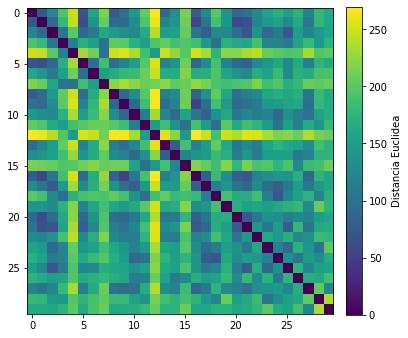

In [65]:
d = euclidean_distances(X, X)
plot_distancia_euclidea(d)